In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [96]:
class Poly_Regression:
    def __init__(self, l, k, degree=1):
        self.l = l
        self.m = degree
        self.k = k
        # self.n = n
        
        # self.X = None
        # self.y = None
        self.B = None
    
    # Converting given data array for x into disired format with three dimensions
    def X_poly(self, X):
        n = X.shape[0]
        powers = np.arange(1, self.m+1)
        # X = X.reshape(n, self.l)
        # X3d = X[:, :, np.newaxis] ** powers[np.newaxis, np.newaxis, :]
        # print(X.shape)
        X3d = X.reshape(n, self.l, 1) ** powers.reshape(1, 1, self.m)
        X3d = np.concatenate((np.ones((n,1)), X3d.reshape(n, self.l*self.m)), axis=1)
        return X3d
    
    def train(self, X_train, y_train):
        # self.l = X_train[0].size
        # self.k = y_train[0].size
        n = X_train.shape[0]
        X_flat = self.X_poly(X_train)
        y = y_train.reshape(n, self.k)
        
        # X_flat = X.reshape(n, self.l*self.m)
        
        # B_flat = np.matmul(np.linalg.inv(np.matmul(X_flat.T, X_flat)), np.matmul(X_flat.T, y))
        # self.B = np.concatenate((B_flat[0,:].reshape(self.l, 1, self.k), B_flat[1:,:].reshape(self.l, self.m, self.k)), axis = 1)
        self.B = np.matmul(np.linalg.inv(np.matmul(X_flat.T, X_flat)), np.matmul(X_flat.T, y))
    
    def make_predictions(self, X):
        n = X.shape[0]
        X_flat = self.X_poly(X)
        # X_flat = X.reshape(n, self.l*self.m)
        # B_flat = self.B.reshape(self.l*(self.m+1), self.k)
        return np.matmul(X_flat, self.B)
    
    def MSE(self, X_test, y_test):
        y_predicted = self.make_predictions(X_test)
        y_test = y_test.reshape(y_predicted.shape)
        return np.mean(((y_predicted - y_test)**2), axis=0)
    
    def SSR(self, X_test, y_test):
        y_predicted = self.make_predictions(X_test)
        y_test = y_test.reshape(y_predicted.shape)
        return np.sum(((y_predicted - y_test)**2), axis=0)
    
    def Rsquared(self, X_test, y_test):
        y_predicted = self.make_predictions(X_test)
        y_test = y_test.reshape(y_predicted.shape)
        Syy = np.sum(((y_test - np.mean(y_test, axis=0))**2), axis=0)
        SSr = self.SSR(X_test, y_test)
        return 1 - SSr/Syy
    
    def MAE(self, X_test, y_test):
        y_predicted = self.make_predictions(X_test)
        y_test = y_test.reshape(y_predicted.shape)
        return np.mean((np.abs(y_predicted - y_test)), axis=0)
    
    def residuals(self, X_test, y_test):
        y_predicted = self.make_predictions(X_test)
        y_test = y_test.reshape(y_predicted.shape)
        resid = np.abs(y_test - y_predicted)
        if y_test.shape[1]==1:
            return resid.reshape(y_test.shape[0])
        return resid

In [68]:
df = pd.read_csv('air-traffic-prediction/AirtrafficA4.csv')

def MonthFormatRefiner(given):
    match given:
        case 'JAN':
            return 1
        case 'FEB':
            return 2
        case 'MAR':
            return 3
        case 'APR':
            return 4
        case 'MAY':
            return 5
        case 'JUNE':
            return 6
        case 'JULY':
            return 7
        case 'AUG':
            return 8
        case 'SEP':
            return 9
        case 'OCT':
            return 10
        case 'NOV':
            return 11
        case 'DEC':
            return 12
        case _:
            return 0

def Month(given):
    return int(MonthFormatRefiner(given))

# Cleansing the months field and removing the recoirds where the name is invalid & creating a sorted date field
df['MONTH'] = (df['MONTH'].str.strip()).apply(Month)
df1 = df[df['MONTH']!=0]
df1 = df1.sort_values(by=['YEAR', 'MONTH'], ascending=[True, True])
df1['DATE'] = pd.to_datetime(df1[['YEAR', 'MONTH']].assign(Day=1))
df1.set_index('DATE', inplace=True)

# Cleansing the numbers in various fields and filling missing values with the average of previous and next values
columns_to_clean = ['TOTAL DEPARTURES', 'HOURS FLOWN', 'KILOMETRE FLOWN', 'PASSENGERS CARRIED', 'AVAILABLE SEAT KILOMETRE (IN THOUSAND)', ' FREIGHT CARRIED (IN TONNE)', 'MAIL CARRIED (IN TONNE)']
for col in columns_to_clean:
    df1[col] = (df1[col].str.replace(r'[^0-9.]', '', regex=True)).str.strip()
    df1[col] = pd.to_numeric(df1[col], errors='coerce')
    df1[col] = df1[col].fillna(df1[col].combine_first((df1[col].shift(1) + df1[col].shift(-1))/2))

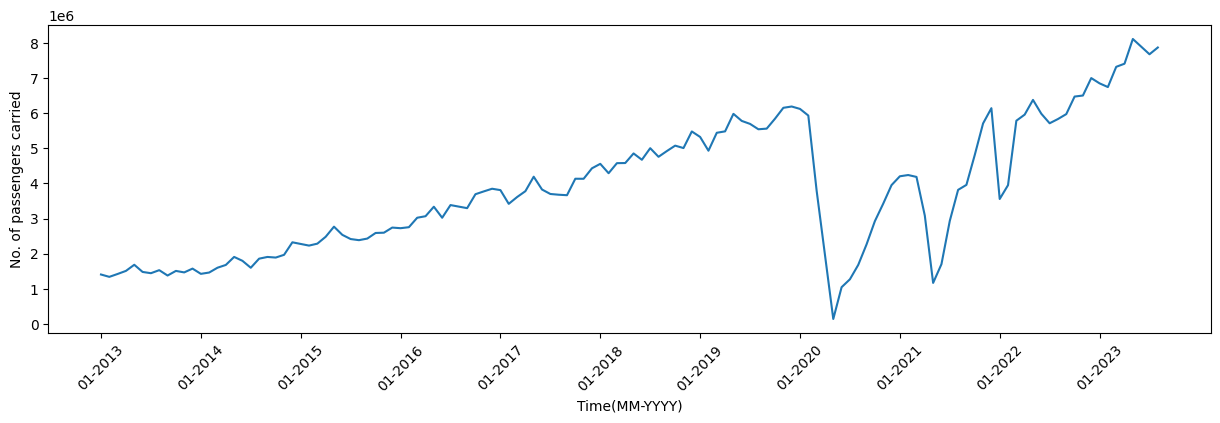

In [180]:
plt.figure(figsize=(15,4))
plt.plot((np.array(df1['YEAR'])-2013)*12 + df1['MONTH'], np.array(df1['PASSENGERS CARRIED']))
ticks = np.arange(1, 132, 12)
labels = [f'0{i%12}-{2013+i//12}' for i in ticks]
plt.xticks(ticks=ticks, labels=labels, rotation=45)
plt.xlabel('Time(MM-YYYY)')
plt.ylabel('No. of passengers carried')
plt.show()

## OLS with quarterly booleans

In [113]:
# Adjusting data for training
dfa = df1
dfa['S1'] = np.where((df1['MONTH'] <=3) & (df1['MONTH'] >=1), 1, 0)
dfa['S2'] = np.where((df1['MONTH'] <=6) & (df1['MONTH'] >=4), 1, 0)
dfa['S3'] = np.where((df1['MONTH'] <=9) & (df1['MONTH'] >=7), 1, 0)
dfa['S4'] = np.where((df1['MONTH'] <=12) & (df1['MONTH'] >=10), 1, 0)

dfa['time_index'] = (np.array(df1['YEAR'])-2013)*12 + df1['MONTH']

MAE: [2005831.2274621]


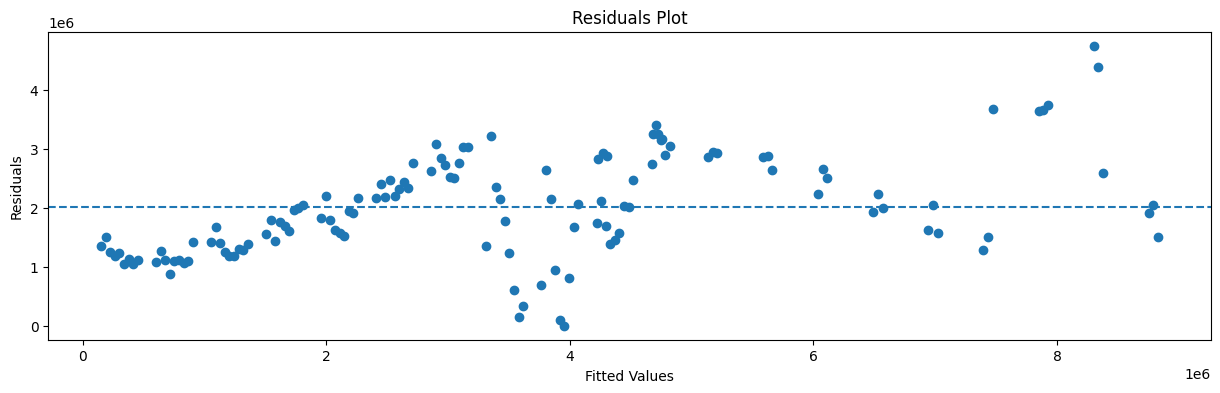

In [178]:
# Training and analysing residuals
X = np.array(dfa[['time_index', 'S1', 'S2', 'S3', 'S4']])
y = np.array(dfa['PASSENGERS CARRIED'])

# modelA = sm.OLS(y, X).fit()
modelA = Poly_Regression(l=5, k=1, degree=1)
modelA.train(X, y)
# print(modelA.summary())
# residuals = modelA.resid
residuals = modelA.residuals(X, y)
print("MAE:",modelA.MAE(X, y))
plt.figure(figsize=(15, 4))
plt.scatter(modelA.make_predictions(X), residuals)
plt.axhline(np.mean(residuals), linestyle='--')
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title('Residuals Plot')
plt.show()

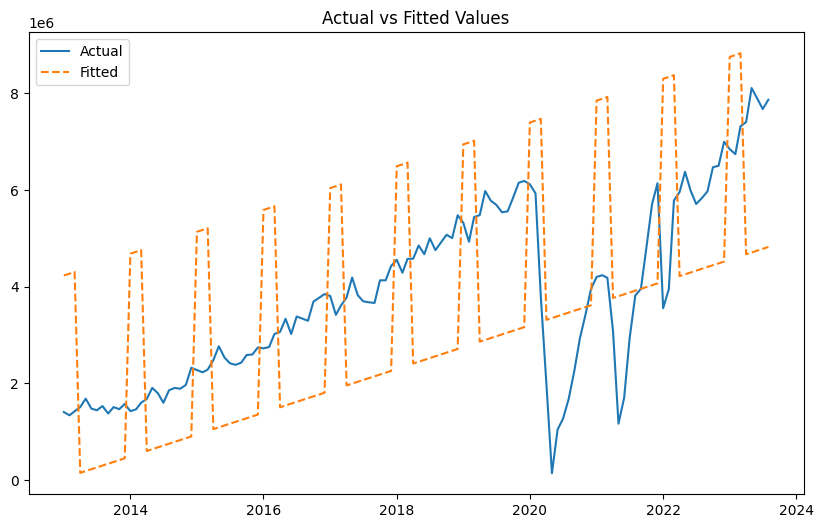

In [175]:
# Plot actual vs fitted values
plt.figure(figsize=(10, 6))
plt.plot(dfa.index, y, label='Actual')
plt.plot(dfa.index, modelA.make_predictions(X), label='Fitted', linestyle='--')
plt.title('Actual vs Fitted Values')
plt.legend()
plt.show()

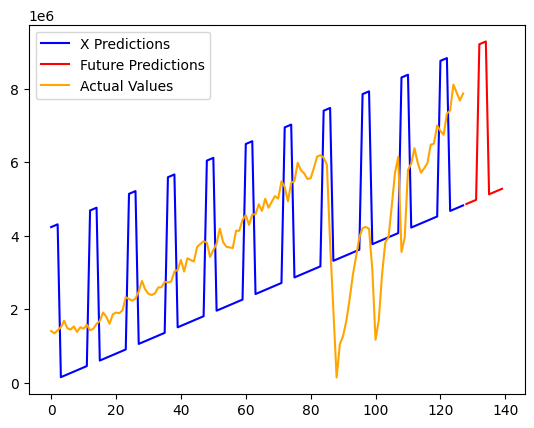

In [176]:
# Forecasting
forecast_months_indices = np.arange((2023-2013)*12+9, (2024-2013)*12+9)
future = np.array(pd.DataFrame({
    'time_index': forecast_months_indices,
    'S1': np.where((forecast_months_indices%12 <=3) & (forecast_months_indices%12 >=1), 1, 0),
    'S2': np.where((forecast_months_indices%12 <=6) & (forecast_months_indices%12 >=4), 1, 0),
    'S3': np.where((forecast_months_indices%12 <=9) & (forecast_months_indices%12 >=7), 1, 0),
    'S4': np.where((forecast_months_indices%12 <=12) & (forecast_months_indices%12 >=10), 1, 0)
}))
X_pred = modelA.make_predictions(X)
future = modelA.make_predictions(future)
forecast = np.concatenate([X_pred, future])
plt.plot(np.arange(len(X_pred)), X_pred, color='blue', label='X Predictions')
plt.plot(np.arange(len(X_pred), len(forecast)), future, color='red', label='Future Predictions')
plt.plot(np.arange(len(X_pred)), y, color='orange', label='Actual Values')
plt.legend()
plt.show()

### Auto Correlation

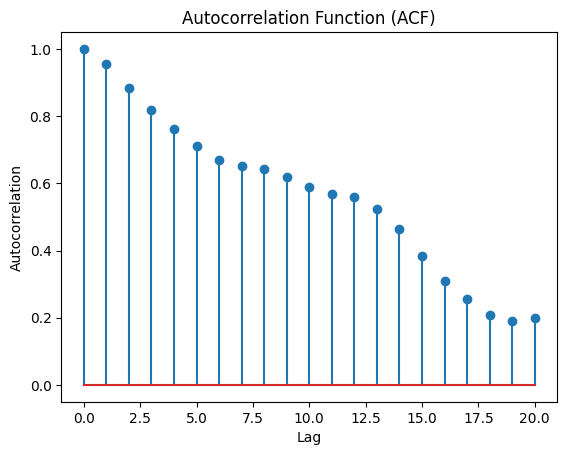

In [177]:
time_series = df1['PASSENGERS CARRIED']
lags = 20
acf_values = [time_series.autocorr(lag) for lag in range(lags + 1)]

# Plot the ACF values
plt.stem(range(lags + 1), acf_values)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function (ACF)')
plt.show()